In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

Using TensorFlow backend.


In [0]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [34]:
if 1:
  !rm *.tgz *.png 
  #!wget https://www.dropbox.com/s/pppk3ltnci0damv/style.tgz
  !wget https://www.dropbox.com/s/kwgbxfg0kokj7n8/portada.PNG
  !wget https://www.dropbox.com/s/zgh8wevjgaq197d/yo.jpg
  #!tar xvzf style.tgz

rm: cannot remove '*.tgz': No such file or directory
rm: cannot remove '*.png': No such file or directory
--2018-05-18 09:52:52--  https://www.dropbox.com/s/kwgbxfg0kokj7n8/portada.PNG
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/3wLOya7BEd0tEW53PQHsvJRd4zPR725Y3VPub4H0EnGEzP2G4QYYbKUZu12jeO2C/file [following]
--2018-05-18 09:52:52--  https://dl.dropboxusercontent.com/content_link/3wLOya7BEd0tEW53PQHsvJRd4zPR725Y3VPub4H0EnGEzP2G4QYYbKUZu12jeO2C/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6, 2620:100:6021:6::a27d:4106
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181789 (178K) [image/png]
Saving to: ‘portada.PNG’

p

In [0]:
content_image=Image.open('yo.jpg')
content_image=content_image.resize((512,512))

In [0]:
style_image= Image.open('portada.PNG')
style_image=style_image.resize((512,512))

In [0]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)

In [77]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)[:,:,:,:3]

print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68

In [0]:
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68

In [0]:
height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

In [0]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)


In [82]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [0]:
content_weight = 0.05
style_weight = 50.0
total_variation_weight = 1.0

In [84]:
layers=dict([(layer.name, layer.output) for layer in model.layers])
print(layers)

{'input_2': <tf.Tensor 'concat_2:0' shape=(3, 512, 512, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>, 'block4

In [0]:
loss=backend.variable(0.)

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [87]:
layer_features=layers['block2_conv2']
print(layer_features.shape)
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)

(3, 256, 256, 128)


In [0]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [0]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [0]:
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

In [0]:
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = backend.gradients(loss, combination_image)

In [0]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [0]:
evaluator=Evaluator()

In [0]:

x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 50

In [0]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
2180942700000.0
Iteration 0 completed in 17s
Start of iteration 1
840888300000.0
Iteration 1 completed in 17s
Start of iteration 2
490594800000.0
Iteration 2 completed in 17s
Start of iteration 3
350196800000.0
Iteration 3 completed in 17s
Start of iteration 4
289184000000.0
Iteration 4 completed in 17s
Start of iteration 5
255873520000.0
Iteration 5 completed in 17s
Start of iteration 6
233675160000.0
Iteration 6 completed in 17s
Start of iteration 7
220273030000.0
Iteration 7 completed in 17s
Start of iteration 8
210943500000.0
Iteration 8 completed in 17s
Start of iteration 9
203228220000.0
Iteration 9 completed in 17s
Start of iteration 10
198033670000.0
Iteration 10 completed in 17s
Start of iteration 11
194094300000.0
Iteration 11 completed in 17s
Start of iteration 12
191137270000.0
Iteration 12 completed in 17s
Start of iteration 13
188617330000.0
Iteration 13 completed in 17s
Start of iteration 14
186474280000.0
Iteration 14 completed in 17s
Start of itera

In [0]:
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

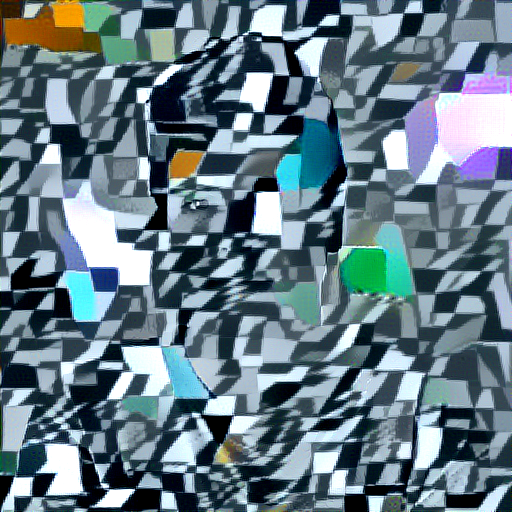

In [109]:
Image.fromarray(x)